In [39]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [40]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

In [41]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()

In [42]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [43]:
from huggingface_hub import notebook_login
notebook_login()

In [44]:
df = pd.read_csv("hf://datasets/Ayon128/CB/final_CB_multi-label_dataset.csv")
df.shape

(5089, 8)

In [45]:
with pd.option_context('display.max_colwidth',0):
    display(df.sample(n=5))

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
416,তোর মত ছাগলকে নাটকে চান্স দিচে কে,Actor,Female,"Insult, Targeted Harassment",0,1,0,1
4020,এরকম কথা হিনদুরাও বলে নাই তুই বড় নাসতিক। তুর উচিত ছিল হিনদু হয়ে জন্ম নেওয়া। আর তুই এটা বলে বলে প্রমান করলি যে তুই হারামের বাচ্চা,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
4024,এ তো আস্তো একটা মাগি।এর রেট কত?,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
3391,"সাফা সবাই তোমারে খেলতে চাচ্ছে! এই সুযোগে পর্ন স্টার হয়ে যাও।নিজেস্ব পর্ন সাইট খুলে বসো!ধান্দা আর ধান্দা! after all, ধান্দে ওয়ালি নিকলি তু :/",Actor,Female,"Trolling, Insult, Targeted Harassment",1,1,0,1
2783,"খোদার কসম মন ডায় চায় তোরে জুতা মারতে মারতে কোর গাল দুটা লাল করে দেয়, মানুষের ভয়ে আল্লার কাছে ক্ষমা চাস,ছি ছি,",Actor,Female,"Insult, Targeted Harassment",0,1,0,1


In [46]:
df.columns

Index(['Comment', 'Profession', 'Gender', 'Labels', 'Trolling', 'Insult',
       'Hate Speech', 'Targeted Harassment'],
      dtype='object')

In [47]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df, random_state=1, test_size=0.3, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=1, test_size=0.50, shuffle=True)

In [48]:
df_train.shape, df_test.shape, df_valid.shape

((3562, 8), (763, 8), (764, 8))

In [49]:
df_test.head()

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
1720,বাপ জেমন মেয়েত তেমনি হবে এটাতো তাদের রেচালা।,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
2702,জুতা মারি তোর চোয়ালে বেটা বেয়াদব । এজন্যই তো ত...,Singer,Female,"Insult, Targeted Harassment",0,1,0,1
4740,"সালা বেগাচেগা তুই লাইভে আসিস কি করতে, আয়নায় কো...",Social,Male,"Trolling, Insult, Targeted Harassment",1,1,0,1
4076,জুতা মার।ছাগলের বাচ্চা,Social,Male,"Insult, Targeted Harassment",0,1,0,1
2445,ওর নোংরা ছবিটা পোস্ট না করে শুধু লেখাটা রাখলেই...,Actor,Female,"Trolling, Insult",1,1,0,0


In [50]:
# checkpoint = "csebuetnlp/banglabert" "sagorsarker/bangla-bert-base" "csebuetnlp/banglabert_large"
class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 16
    MODEL_PATH = "csebuetnlp/banglabert"
    LR = 3e-5
    DROPOUT = 0.3
    NUM_CLASSES = 4
    SEED = 0
    MAX_LEN = 128
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [51]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

<Axes: ylabel='Count'>

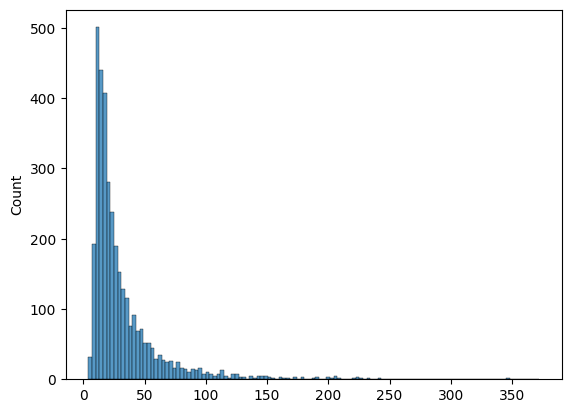

In [52]:
token_counts = []

for _, row in df_train.iterrows():
    text = str(row["Comment"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

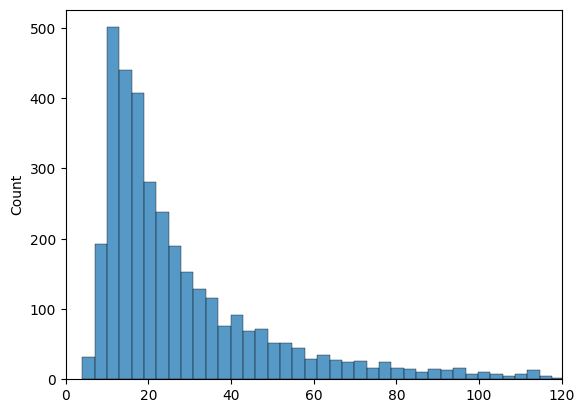

In [53]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

<Axes: ylabel='Count'>

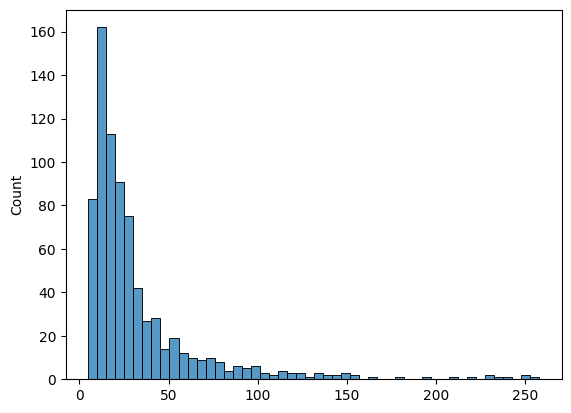

In [54]:
token_counts = []

for _, row in df_valid.iterrows():
    text = str(row["Comment"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

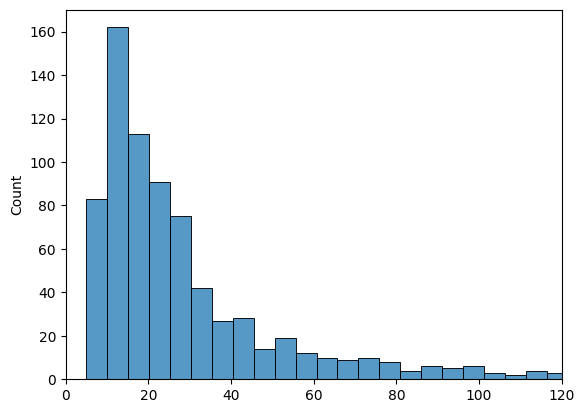

In [55]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

In [56]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer, target_list):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.targets = self.df[target_list].values
        # self.labels = torch.tensor(df.Label.values, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["Comment"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        # labels = self.labels[index]
        labels = torch.FloatTensor(self.targets[index])

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [57]:
target_list = list(df.columns)
target_list

['Comment',
 'Profession',
 'Gender',
 'Labels',
 'Trolling',
 'Insult',
 'Hate Speech',
 'Targeted Harassment']

In [58]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [59]:
target_list = target_list[4:]

In [60]:
target_list

['Trolling', 'Insult', 'Hate Speech', 'Targeted Harassment']

In [61]:
import torch.nn.functional as F
class LSTMPooling(nn.Module):
    def __init__(self, num_layers, hidden_size, hiddendim_lstm):
        super(LSTMPooling, self).__init__()
        self.num_hidden_layers = num_layers
        self.hidden_size = hidden_size
        self.hiddendim_lstm = hiddendim_lstm
        self.lstm = nn.LSTM(self.hidden_size, self.hiddendim_lstm, batch_first=True)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, all_hidden_states):
        ## forward
        hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze()
                                     for layer_i in range(1, self.num_hidden_layers+1)], dim=-1)
        hidden_states = hidden_states.view(-1, self.num_hidden_layers, self.hidden_size)
        out, _ = self.lstm(hidden_states, None)
        out = self.dropout(out[:, -1, :])
        return out

In [62]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        self.model_config = AutoConfig.from_pretrained(config.MODEL_PATH)
        self.model = AutoModel.from_pretrained(
            config.MODEL_PATH, 
            config=self.model_config
        )
        # LSTM pooler
        self.lstm_pooler = LSTMPooling(
            self.model_config.num_hidden_layers, 
            self.model_config.hidden_size, 
            768
        )
        
        # Combined dimension: LSTM hidden dim + model hidden size (for CLS token)
        combined_dim = 768 + self.model_config.hidden_size
        
        self.dropout = torch.nn.Dropout(config.DROPOUT)
        # Classifier takes the combined dimension as input
        self.classifier = nn.Linear(combined_dim, config.NUM_CLASSES)
        
    def forward(self, input_ids, attention_mask):
        # Get hidden states from the model
        outputs = self.model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        
        # Get all hidden states
        all_hidden_states = outputs.hidden_states
        
        # Get LSTM pooled representation
        lstm_output = self.lstm_pooler(all_hidden_states)
        
        # Get CLS token from the last layer
        cls_output = all_hidden_states[-1][:, 0]
        
        # Concatenate CLS and LSTM outputs
        combined = torch.cat([cls_output, lstm_output], dim=-1)
        
        # Apply dropout and classifier
        output_dropout = self.dropout(combined)
        output = self.classifier(output_dropout)
        
        return output

In [63]:
class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        y_pred = torch.sigmoid(pred).cpu().detach().numpy().round()
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)            
            target = data["labels"].to(config.DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(config.DEVICE)  
                attention_mask = data["attention_mask"].to(config.DEVICE)              
                target = data["labels"].to(config.DEVICE)  
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [64]:
# Run training function with improved training procedure
from transformers import get_cosine_schedule_with_warmup
history = defaultdict(list)
def run_training(save_model = False):
    train_dataset = ClassifierDataset(df_train, tokenizer, target_list)
    valid_dataset = ClassifierDataset(df_valid, tokenizer, target_list)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE,
        collate_fn=data_collator, 
        shuffle=True, 
        num_workers=2
    )    
    
    val_loader = DataLoader(
        valid_dataset, 
        batch_size=config.BATCH_SIZE,
        collate_fn=data_collator, 
        shuffle=False, 
        num_workers=2
    )   
    
    set_random_seed(config.SEED)
    model = ClassifierModel()
    model.to(config.DEVICE)
    
    # Use differential learning rates
    optimizer_grouped_parameters = [
        # BanglaBERT parameters
        {
            'params': [p for n, p in model.named_parameters() if 'model' in n],
            'lr': config.LR,
            'weight_decay': 0.01
        },
        # Task-specific parameters (including LSTM)
        {
            'params': [p for n, p in model.named_parameters() if 'model' not in n],
            'lr': config.LR * 3,  # Higher learning rate for task-specific layers
            'weight_decay': 0.01
        }
    ]
    
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    warmup_steps = int(0.1 * num_training_steps) 
    
    # Use cosine scheduler with warmup
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )
    
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader, scaler, num_training_steps)
        val_score, val_loss = eng.evaluate(val_loader)
        
        print(f"Epoch: {epoch + 1} | Training_loss: {round(train_loss, 4)} | Val_loss: {round(val_loss, 4)} | Val_f1: {round(val_score, 4)}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if val_score > best_score:
            best_score = val_score
            early_stopping_counter = 0
            
            if save_model:
                torch.save(model.state_dict(), f"banglabert_cyberbullying_model.bin")
                print(f"Saved new best model with F1: {round(val_score, 4)}")
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter > early_stopping_iter:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
            
    del model
    gc.collect()
            
    return round(best_score, 5), history

In [65]:
score =run_training(save_model = True)
print(f"Best f1 Score: {score}")

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

  0%|          | 0/3345 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1 | Training_loss: 0.6385 | Val_loss: 0.6212 | Val_f1: 0.5398
Saved new best model with F1: 0.5398


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2 | Training_loss: 0.5497 | Val_loss: 0.4958 | Val_f1: 0.7965
Saved new best model with F1: 0.7965


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3 | Training_loss: 0.4324 | Val_loss: 0.4324 | Val_f1: 0.8151
Saved new best model with F1: 0.8151


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4 | Training_loss: 0.3622 | Val_loss: 0.4139 | Val_f1: 0.8268
Saved new best model with F1: 0.8268


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5 | Training_loss: 0.3187 | Val_loss: 0.4093 | Val_f1: 0.8255


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 6 | Training_loss: 0.2848 | Val_loss: 0.3909 | Val_f1: 0.842
Saved new best model with F1: 0.842


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 7 | Training_loss: 0.2562 | Val_loss: 0.3983 | Val_f1: 0.8407


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 8 | Training_loss: 0.2295 | Val_loss: 0.4145 | Val_f1: 0.8447
Saved new best model with F1: 0.8447


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 9 | Training_loss: 0.2076 | Val_loss: 0.4305 | Val_f1: 0.8375


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 10 | Training_loss: 0.1861 | Val_loss: 0.4408 | Val_f1: 0.8365


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9d9fb28680>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d9d9fb28680>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    
  if w.is_alive():
         ^  ^ ^^^^^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self.

Epoch: 11 | Training_loss: 0.1779 | Val_loss: 0.4207 | Val_f1: 0.8452
Saved new best model with F1: 0.8452


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 12 | Training_loss: 0.1695 | Val_loss: 0.4296 | Val_f1: 0.8414


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 13 | Training_loss: 0.1626 | Val_loss: 0.4443 | Val_f1: 0.8399


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 14 | Training_loss: 0.1599 | Val_loss: 0.4347 | Val_f1: 0.8391


  0%|          | 0/3345 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 15 | Training_loss: 0.1566 | Val_loss: 0.4336 | Val_f1: 0.8399
Best f1 Score: (0.84524, defaultdict(<class 'list'>, {'train_loss': [0.6385353338558043, 0.5496884989364265, 0.43235700159864043, 0.3622093672442329, 0.3186975172950548, 0.2847532821744012, 0.25619606419796365, 0.22946242777622333, 0.20759576592477447, 0.1860731642342469, 0.1779022949158878, 0.16947732915926408, 0.16256681368623613, 0.15994196543845896, 0.15664667008035385], 'val_loss': [0.6212453246116638, 0.4957504831254482, 0.43235074045757454, 0.4139461036150654, 0.40926877502352, 0.39086435952534276, 0.3982870876789093, 0.4144916022196412, 0.4304623734205961, 0.4408162484566371, 0.4206864917650819, 0.4296135390177369, 0.44428453873842955, 0.4346815946822365, 0.43356200742224854]}))


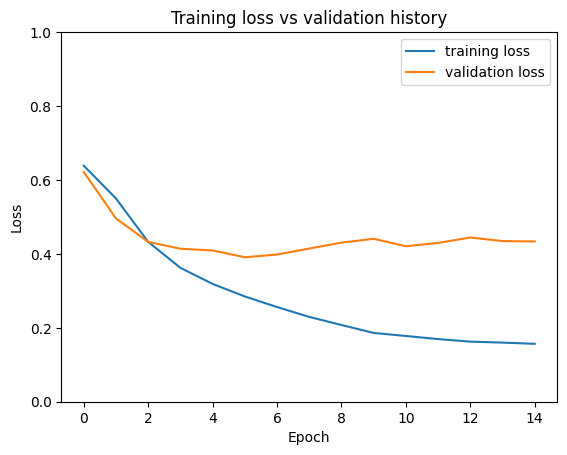

In [66]:
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training loss vs validation history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [67]:
 model = ClassifierModel()

In [ ]:
model_path = f"/kaggle/working/banglabert_cyberbullying_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.to(config.DEVICE);

In [70]:
test_dataset = ClassifierDataset(df_test, tokenizer, target_list)

In [71]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    test_dataset, batch_size=64, collate_fn=data_collator, shuffle=False
)

In [72]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()

    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        input_ids = data["input_ids"].to(config.DEVICE)
        attention_mask = data["attention_mask"].to(config.DEVICE)
        targets = data["labels"].to(config.DEVICE)
        
        outputs = model(input_ids, attention_mask)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return  predictions, prediction_probs, target_values


In [73]:
predictions, prediction_probs, target_values = get_predictions(model, test_dataloader)

In [74]:
predictions= predictions.numpy()
predictions

array([[1., 1., 0., 0.],
       [0., 1., 0., 1.],
       [1., 1., 0., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 0., 0.],
       [0., 1., 1., 1.]], dtype=float32)

In [75]:
print(f"\npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")
     


predictions:(763, 4) 
prediction_probs:torch.Size([763, 4]) 
target_values:torch.Size([763, 4])


In [76]:
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report with 4 decimal digits
print(classification_report(target_values, predictions, target_names=target_list, digits=4))

                     precision    recall  f1-score   support

           Trolling     0.8557    0.7814    0.8169       334
             Insult     0.9118    0.9324    0.9220       621
        Hate Speech     0.8459    0.8678    0.8567       348
Targeted Harassment     0.8339    0.9316    0.8801       512

          micro avg     0.8662    0.8920    0.8789      1815
          macro avg     0.8619    0.8783    0.8689      1815
       weighted avg     0.8669    0.8920    0.8783      1815
        samples avg     0.8685    0.8982    0.8676      1815



In [77]:
subset_acc = (predictions == target_values).all(dim=1).float().mean().item()
print(f"Subset Accuracy: {subset_acc:.4f}")


Subset Accuracy: 0.5675


In [78]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

f1 = f1_score(target_values.numpy(), predictions, average='macro')
print(f"F1 Score (macro): {f1:.4f}")
precision = precision_score(target_values, predictions, average='macro')
print(f"Precision (Macro): {precision:.4f}")

# Recall
recall = recall_score(target_values, predictions, average='macro')
print(f"Recall (Macro): {recall:.4f}")

F1 Score (macro): 0.8689
Precision (Macro): 0.8619
Recall (Macro): 0.8783


In [79]:
f1 = f1_score(target_values.numpy(), predictions, average='micro')
print(f"F1 Score (micro): {f1:.4f}")

F1 Score (micro): 0.8789


In [84]:
type(target_values)

torch.Tensor

In [95]:
df_test

,Comment,Profession,Gender,Labels,Trolling,Insult,Hate Speech,Targeted Harassment
1720,বাপ জেমন মেয়েত তেমনি হবে এটাতো তাদের রেচালা।,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
2702,জুতা মারি তোর চোয়ালে বেটা বেয়াদব । এজন্যই তো ত...,Singer,Female,"Insult, Targeted Harassment",0,1,0,1
4740,"সালা বেগাচেগা তুই লাইভে আসিস কি করতে, আয়নায় কো...",Social,Male,"Trolling, Insult, Targeted Harassment",1,1,0,1
4076,জুতা মার।ছাগলের বাচ্চা,Social,Male,"Insult, Targeted Harassment",0,1,0,1
2445,ওর নোংরা ছবিটা পোস্ট না করে শুধু লেখাটা রাখলেই...,Actor,Female,"Trolling, Insult",1,1,0,0
...,...,...,...,...,...,...,...,...
867,ওর মনে হয় জন্মের ঠিক নেই,Actor,Female,"Insult, Targeted Harassment",0,1,0,1
1919,নটি মাগি তোর মাইরো . আর তোরে উদুম কইরা চুদুম,Actor,Female,"Insult, Hate Speech, Targeted Harassment",0,1,1,1
2497,কিযে কষ্ট আছি বলে বোঝাতে পারবো নাহ মাননীয় স্পি...,Actor,Female,"Trolling, Insult, Hate Speech",1,1,1,0
795,তুমি ভুল শিকার করলা!বাট তুমার আচুদা ফ্যানরা এখ...,Actor,Female,"Trolling, Insult",1,1,0,0


In [97]:
df_test.columns

Index(['Comment', 'Profession', 'Gender', 'Labels', 'Trolling', 'Insult',
       'Hate Speech', 'Targeted Harassment'],
      dtype='object')

In [86]:
type(predictions)

numpy.ndarray

In [88]:
predictions = torch.tensor(predictions)

# Ensure both are float tensors
predictions = predictions.float()
target_values = target_values.float()

# Hamming Accuracy
hamming_acc = (predictions == target_values).float().mean().item()
print(f"Hamming Accuracy: {hamming_acc:.4f}")

# Hamming Loss
hamming_loss = (predictions != target_values).float().mean().item()
print(f"Hamming Loss: {hamming_loss:.4f}")


Hamming Accuracy: 0.8539
Hamming Loss: 0.1461


In [105]:
df = df_test

In [108]:
df["Pred_Trolling"] = predictions[:, 0]
df["Pred_Insult"] = predictions[:, 1]
df["Pred_Hate_Speech"] = predictions[:, 2]
df["Pred_Targeted_Harassment"] = predictions[:, 3]
cols_to_convert = [
    "Trolling", "Insult", "Hate Speech", "Targeted Harassment",
    "Pred_Trolling", "Pred_Insult", "Pred_Hate_Speech", "Pred_Targeted_Harassment"
]

df[cols_to_convert] = df[cols_to_convert].astype(int)

keep_cols = [
    "Trolling", "Insult", "Hate Speech", "Targeted Harassment",
    "Pred_Trolling", "Pred_Insult", "Pred_Hate_Speech", "Pred_Targeted_Harassment"
]

df_clean = df[keep_cols]
df_clean.to_csv("true_pred_only_seed(0).csv", index=False)

print("Saved: true_pred_only.csv")
df_clean.head()


Saved: true_pred_only.csv


,Trolling,Insult,Hate Speech,Targeted Harassment,Pred_Trolling,Pred_Insult,Pred_Hate_Speech,Pred_Targeted_Harassment
1720,0,1,1,1,1,1,0,0
2702,0,1,0,1,0,1,0,1
4740,1,1,0,1,1,1,0,1
4076,0,1,0,1,0,1,0,1
2445,1,1,0,0,1,1,0,1


In [109]:
df_clean.shape

(763, 8)